In [131]:
import torch
import h5py
import numpy as np
import matplotlib.pyplot as plt
from aging.size_norm.data import AugmentationParams, load_tps_points, create_tps_kernels, select_tps_points
from aging.organization.paths import FOLDERS
from kornia.geometry.transform import warp_image_tps, get_tps_transform

In [2]:
params = AugmentationParams()

In [3]:
warp_pts = load_tps_points(params.neutral_pose_warping_path)

In [4]:
import random

In [108]:
random.seed(0)
points = random.choice(list(warp_pts.values()))
source, target = random.choice(points)

In [109]:
source

array([[21.96953237, 39.99102731],
       [33.6286859 , 30.34267175],
       [33.81375183, 49.27529397],
       [26.78124653, 33.98356064],
       [25.85591688, 45.08827175],
       [43.62224607, 32.1631162 ],
       [44.17744385, 48.18302731],
       [60.64831153, 39.62693842],
       [52.69047659, 34.34764953],
       [52.69047659, 45.81644953]])

In [110]:
target

array([[21.96953237, 39.99102731],
       [33.6286859 , 30.34267175],
       [33.81375183, 49.27529397],
       [25.91460144, 33.49561501],
       [24.92461071, 46.82819871],
       [43.62224607, 32.1631162 ],
       [44.72442536, 49.52308265],
       [60.64831153, 39.62693842],
       [52.69047659, 34.34764953],
       [53.77576921, 47.3955427 ]])

In [111]:
device = 'cpu'

In [112]:
source = torch.tensor(source, dtype=torch.float32, device=device)
target = torch.tensor(target, dtype=torch.float32, device=device)
# expand source, kernel, affine, to batch size n
source = source.expand(20, *source.shape)
target = target.expand(20, *target.shape)


In [113]:
target = target + torch.randn_like(target) * 0.1

In [114]:
target[2]

tensor([[21.9337, 39.6905],
        [33.7106, 30.3252],
        [33.9437, 49.4121],
        [25.8925, 33.6773],
        [24.8916, 46.8193],
        [43.5265, 32.1061],
        [44.6400, 49.4726],
        [60.6475, 39.5857],
        [52.7313, 34.2671],
        [53.6635, 47.4623]])

In [115]:
source, kernel, affine = create_tps_kernels(source, target)

In [36]:
# source, kernel, affine = select_tps_points(warp_pts, 10)

In [18]:
files = sorted(FOLDERS[1].glob("**/results_00.h5"))


In [20]:
with h5py.File(files[0], 'r') as h5f:
    frames = h5f['frames'][:4000]

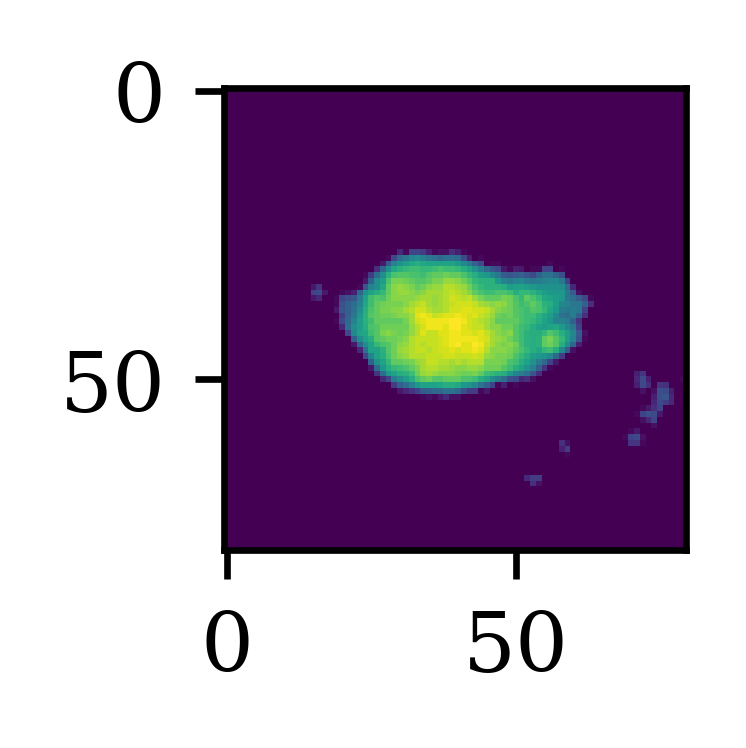

In [24]:
plt.figure(figsize=(1, 1))
plt.imshow(frames[0])

In [129]:
img = np.median(frames, axis=0)

In [116]:
warps = warp_image_tps(torch.tensor(frames[:20], dtype=torch.float32).unsqueeze(1), source, kernel, affine)

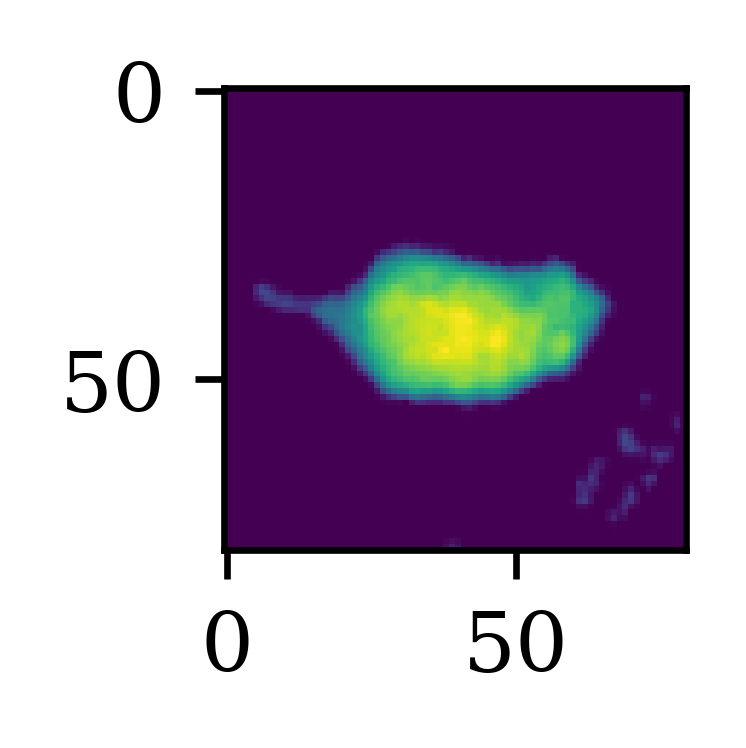

In [122]:
plt.figure(figsize=(1, 1))
plt.imshow(warps[3].squeeze())

In [123]:
def warp(src, dest, img):
    src = torch.tensor(src.copy()).unsqueeze(0).float()
    dest = torch.tensor(dest.copy()).unsqueeze(0).float()
    src = src / 80.0 - 0.5
    dest = dest / 80.0 - 0.5
    kernel_weights, affine_weights = get_tps_transform(dest, src)

    img = torch.tensor(img, dtype=torch.float)
    img = img.view(1, 1, *img.shape)
    out = warp_image_tps(img, src, kernel_weights, affine_weights)
    return out.squeeze().detach().numpy()

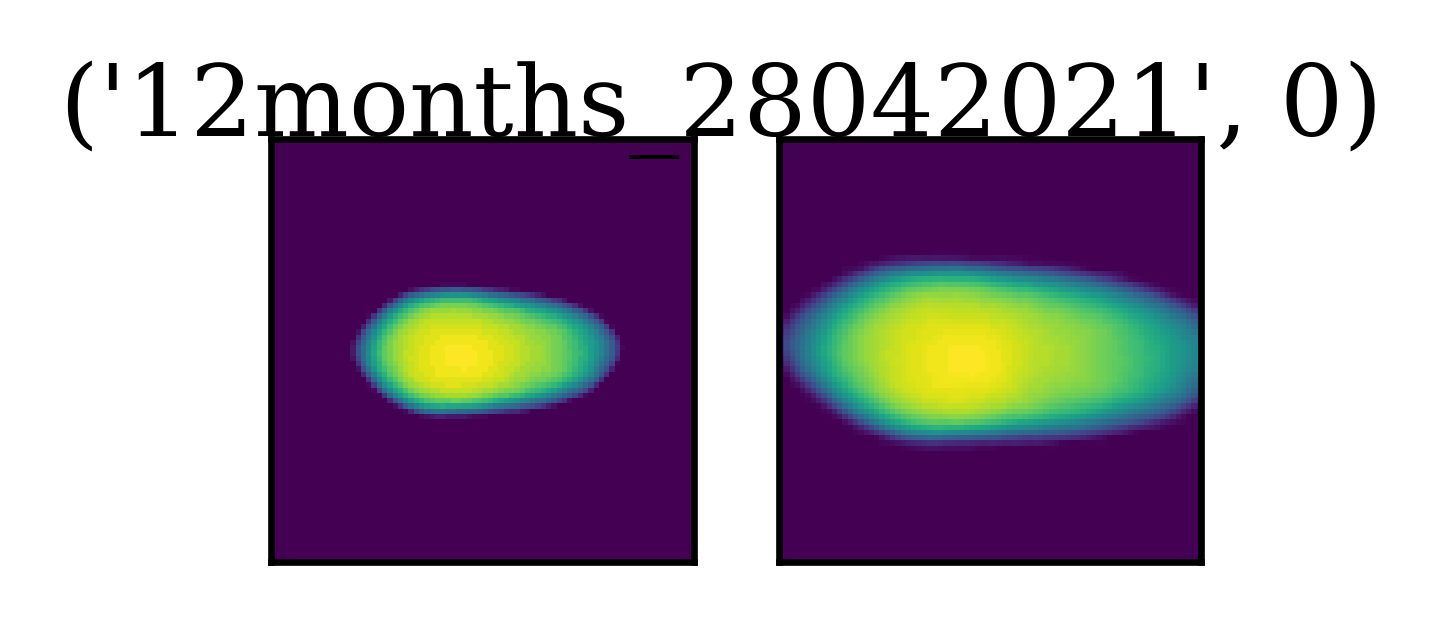

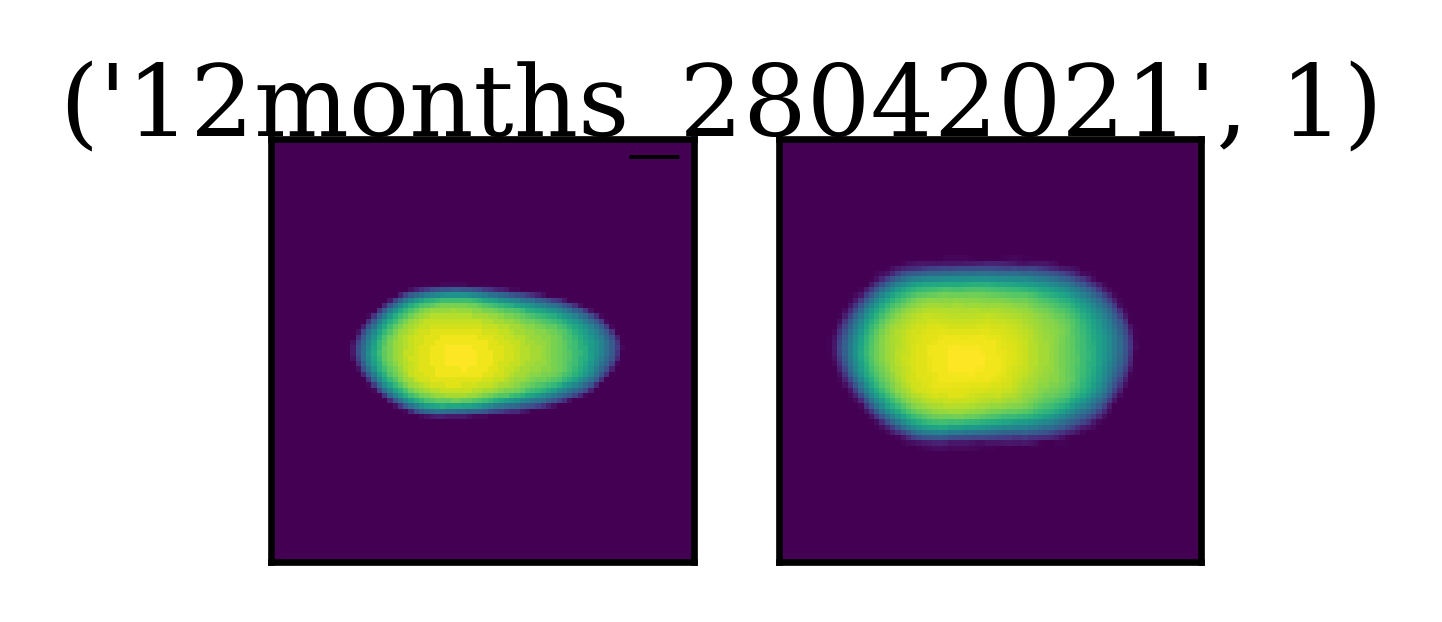

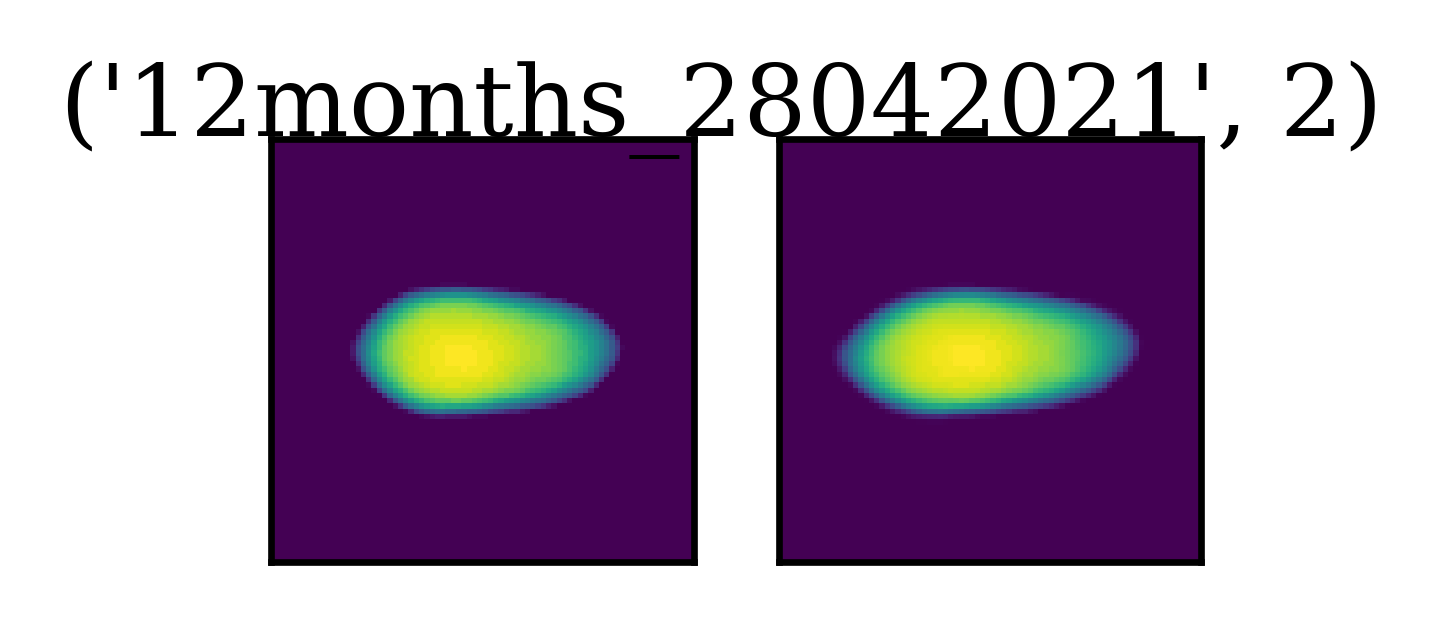

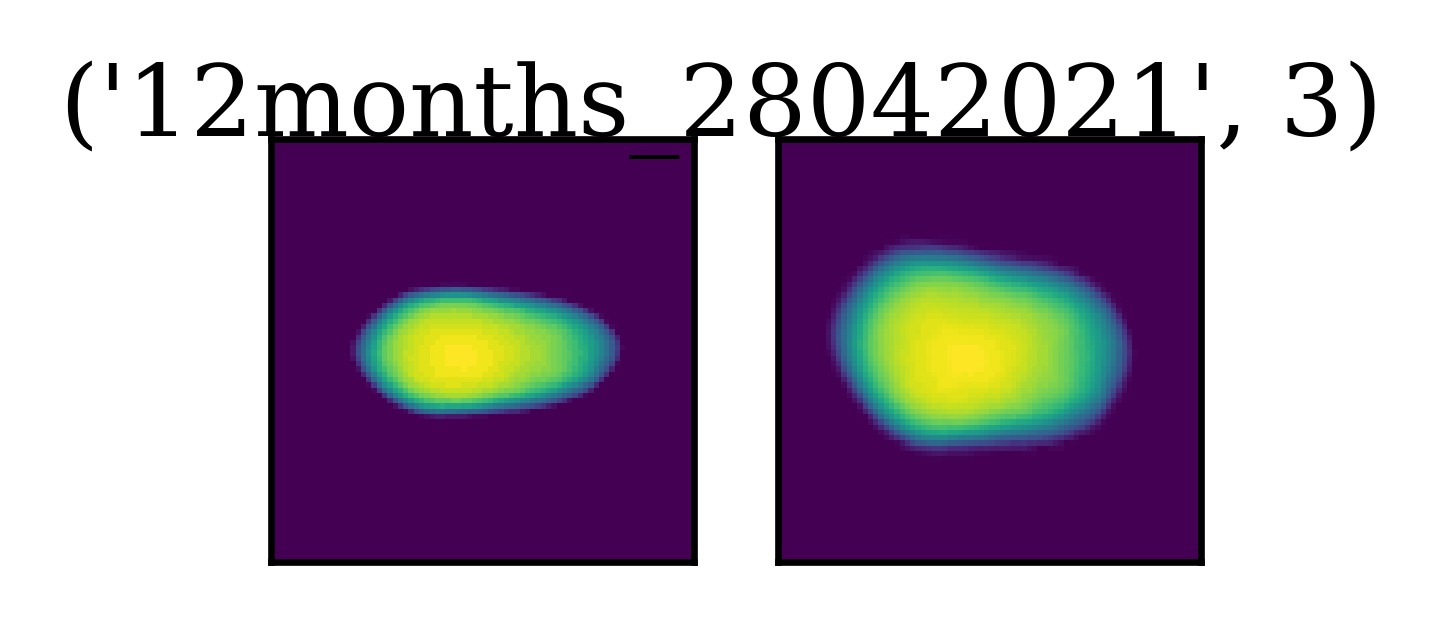

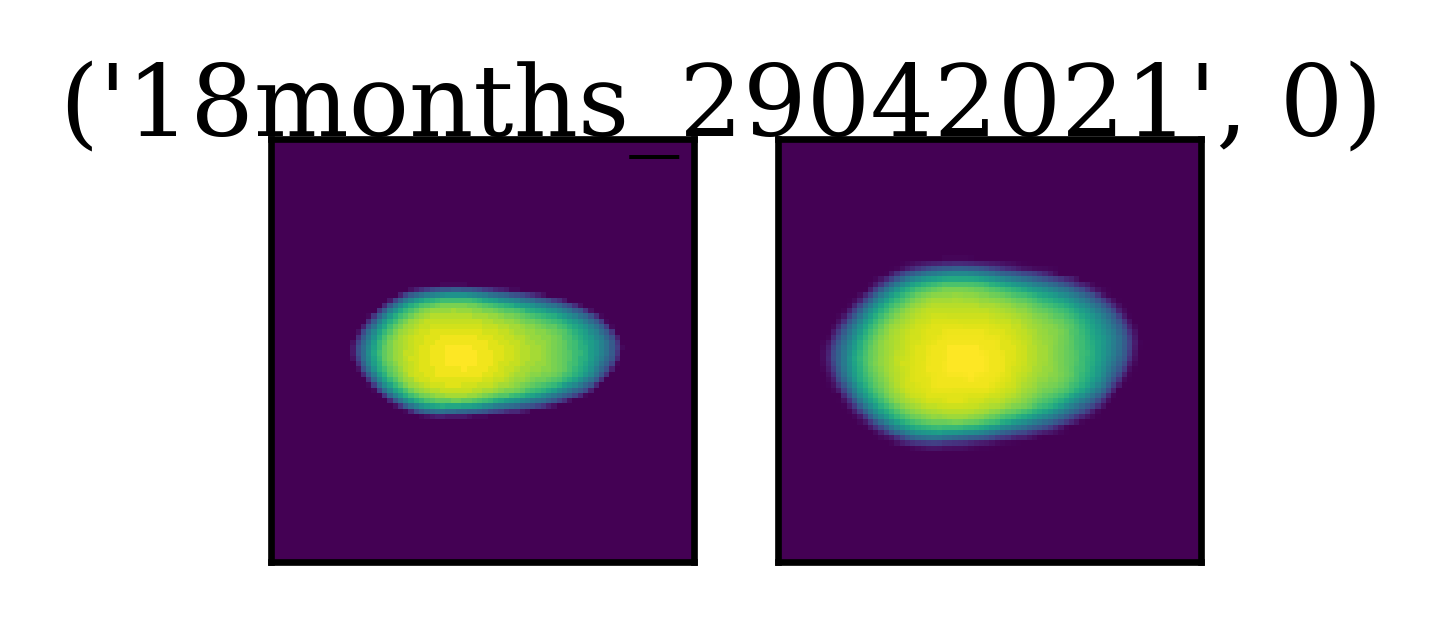

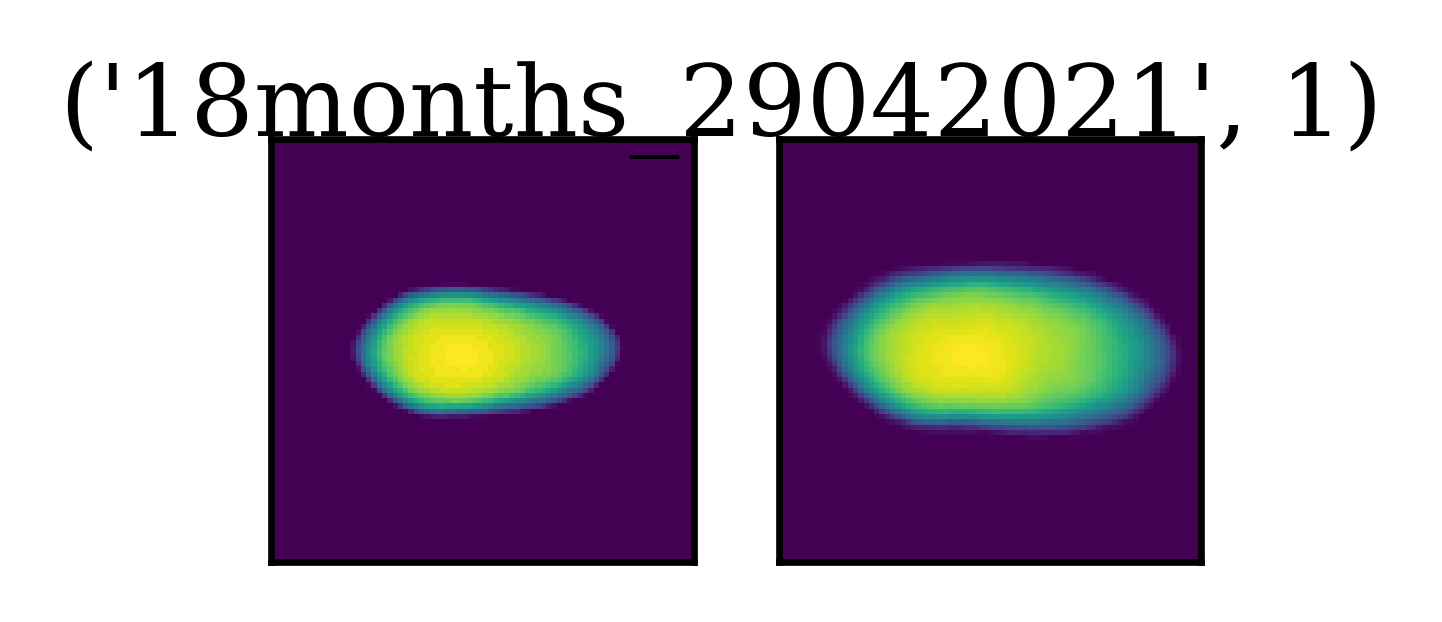

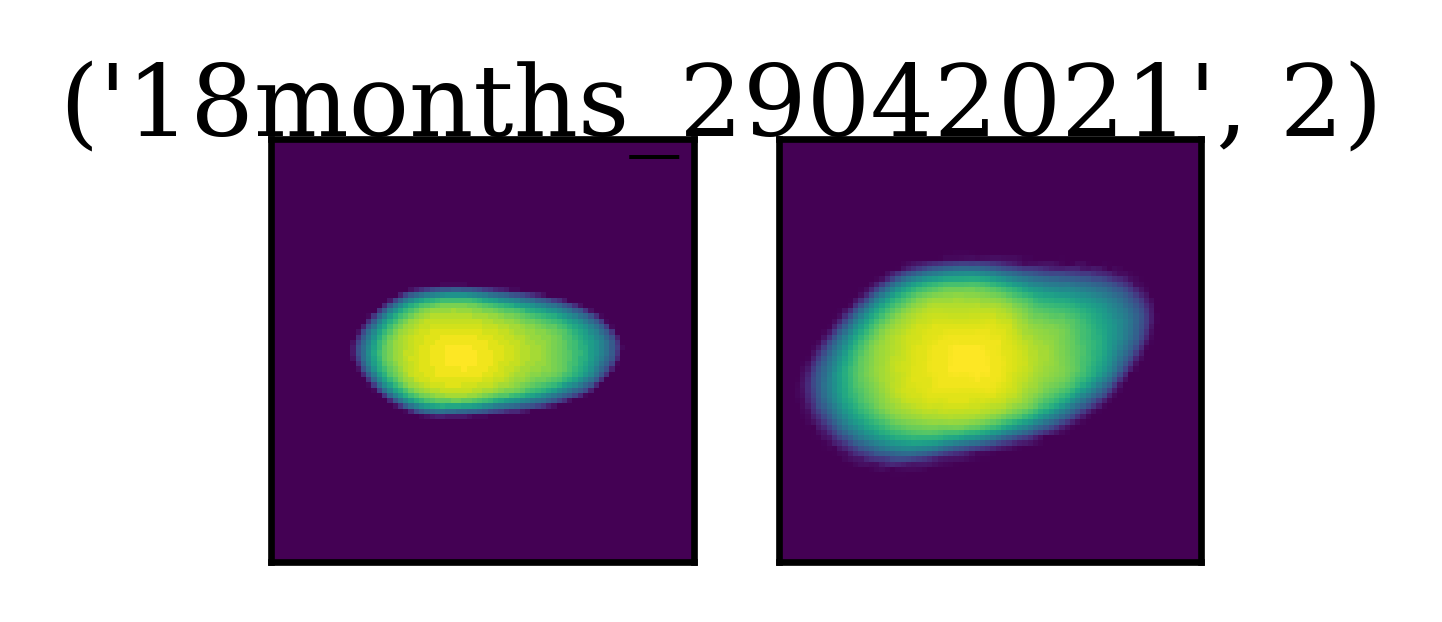

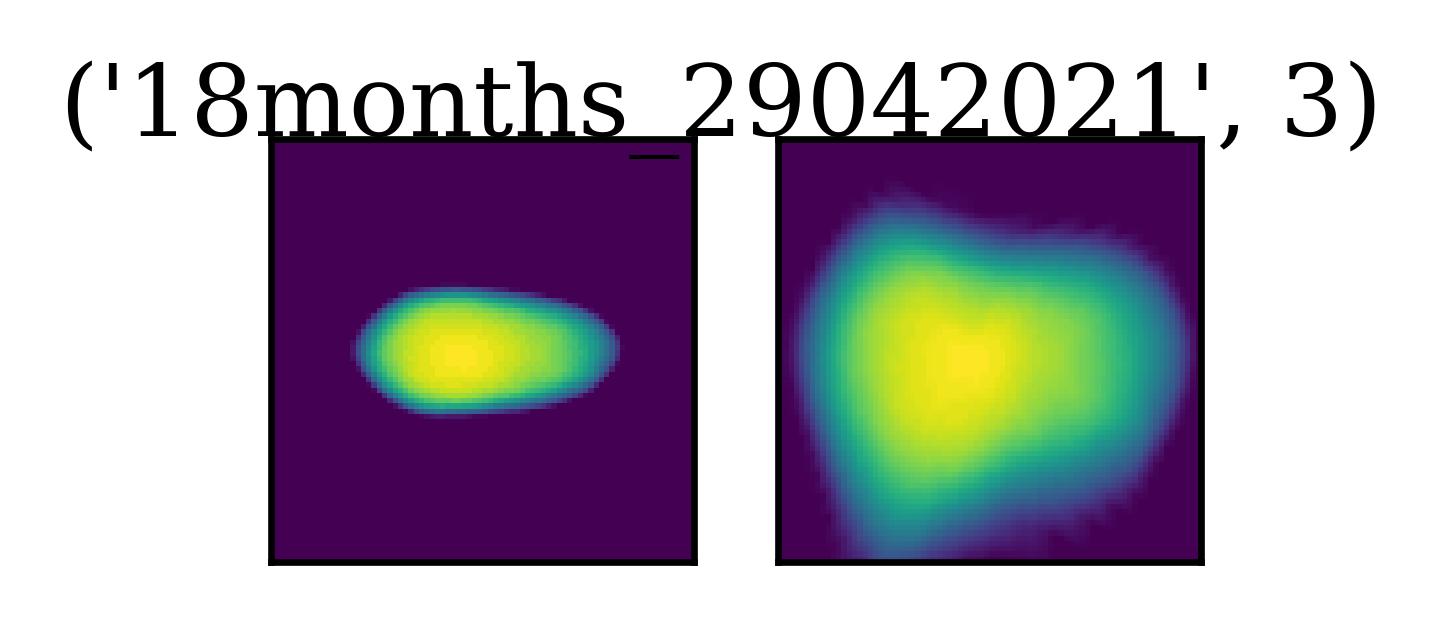

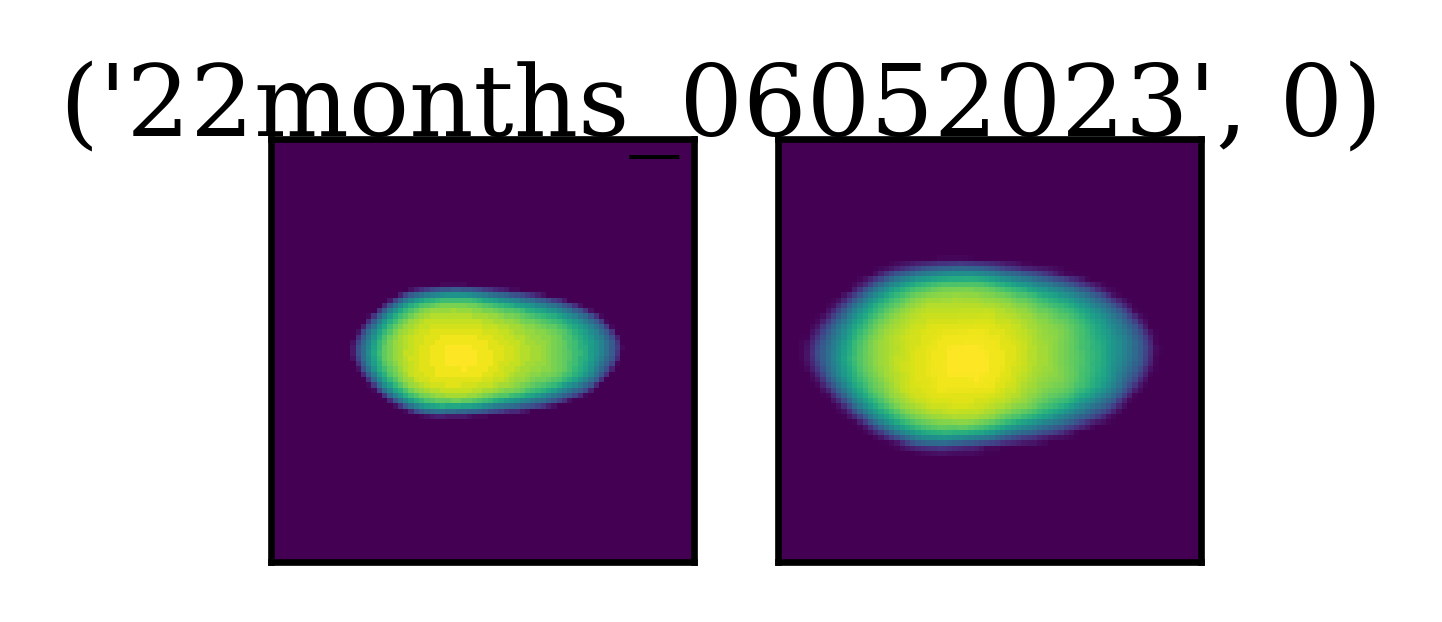

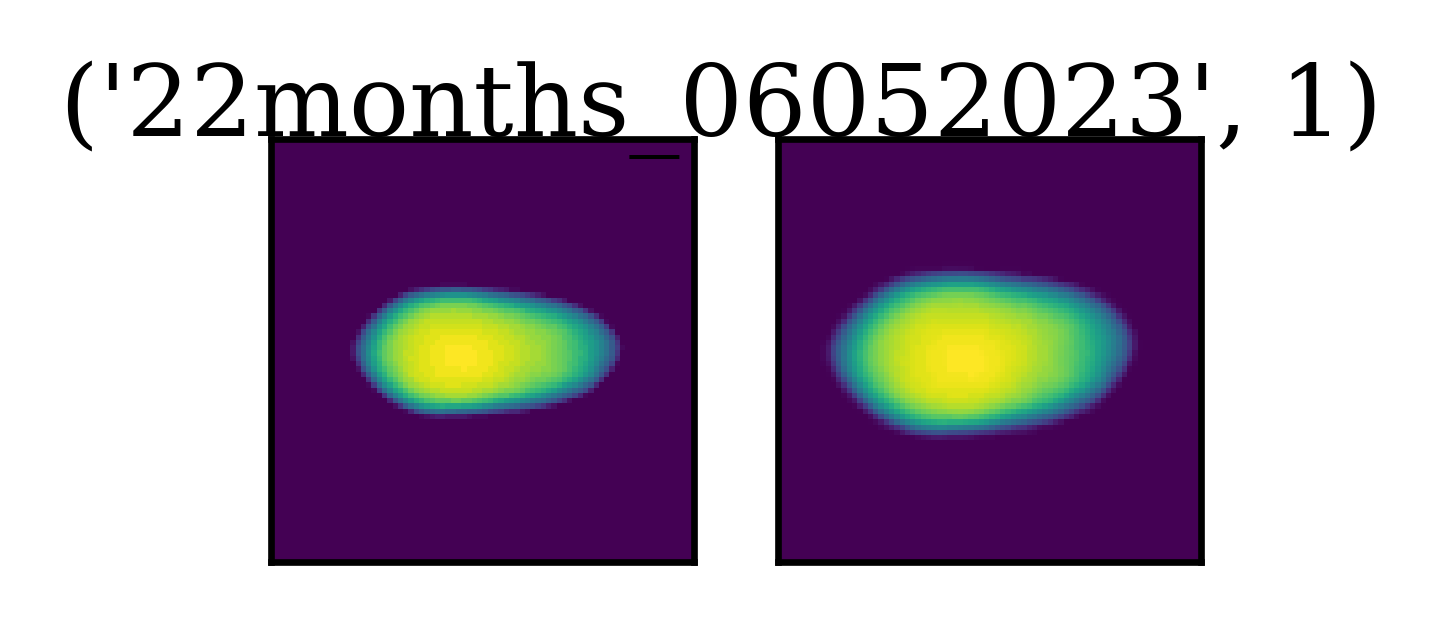

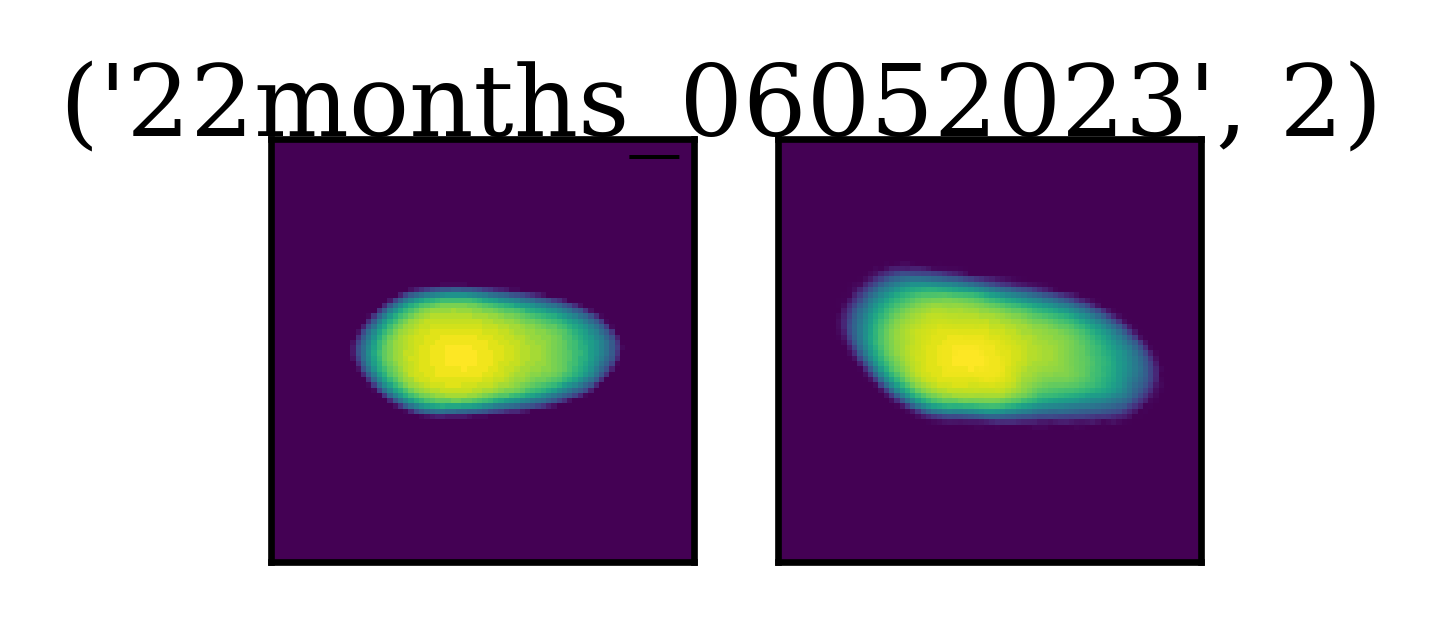

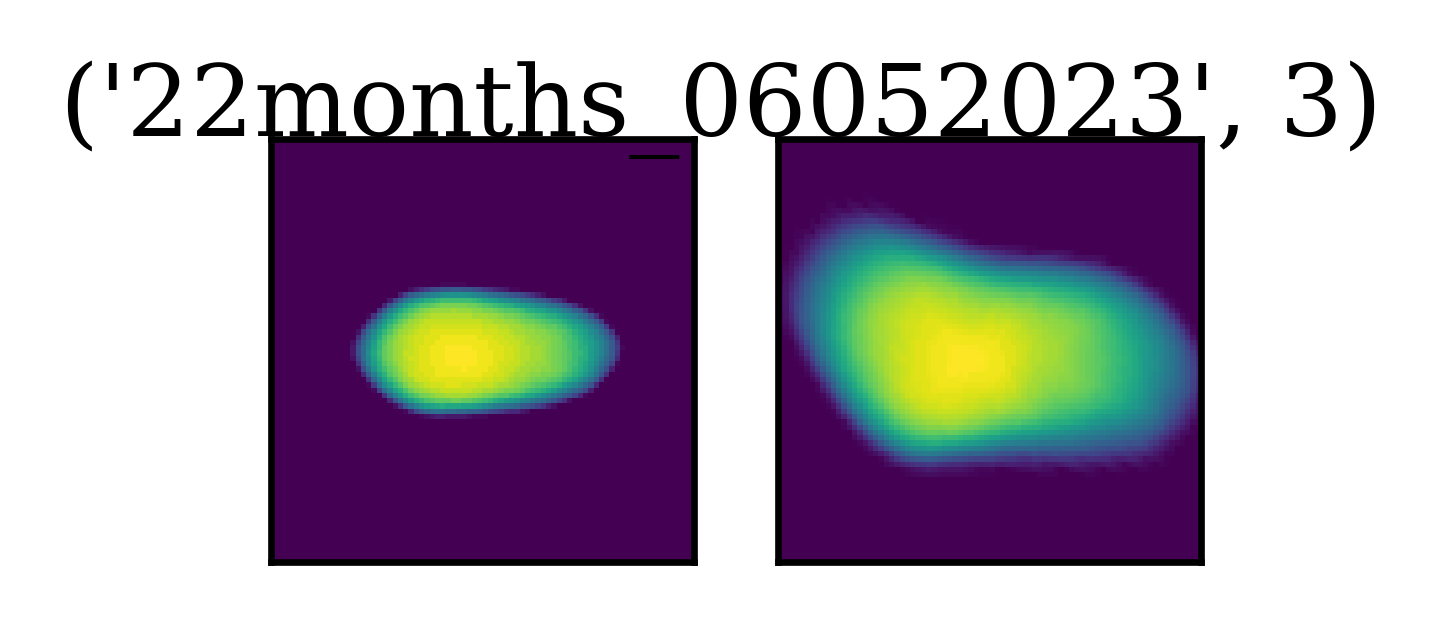

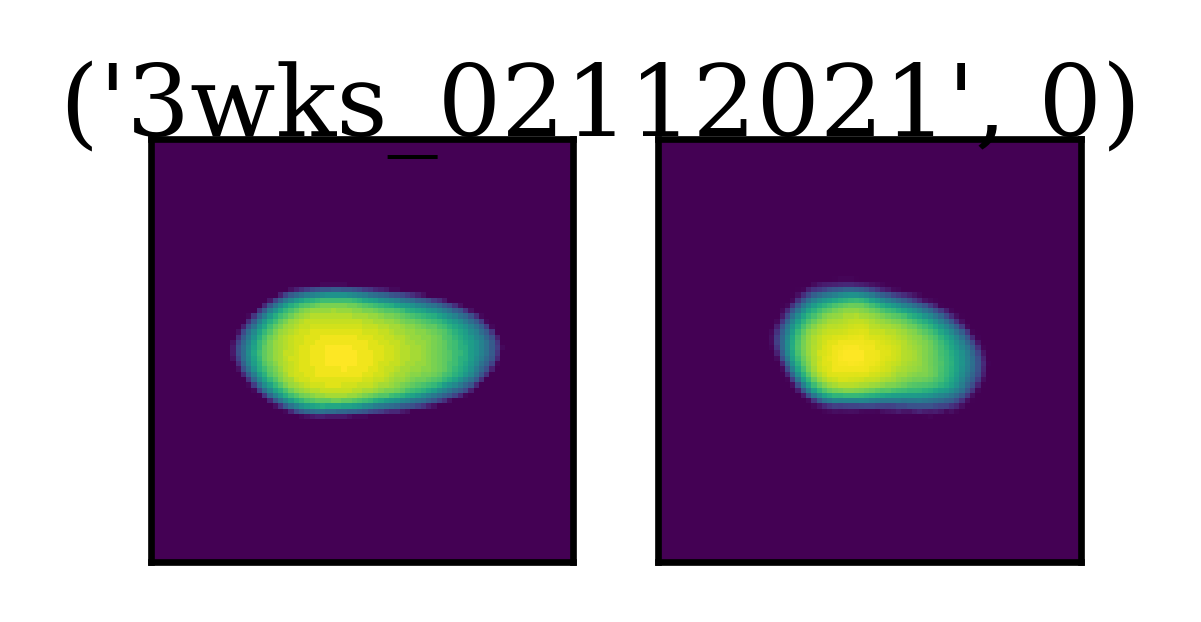

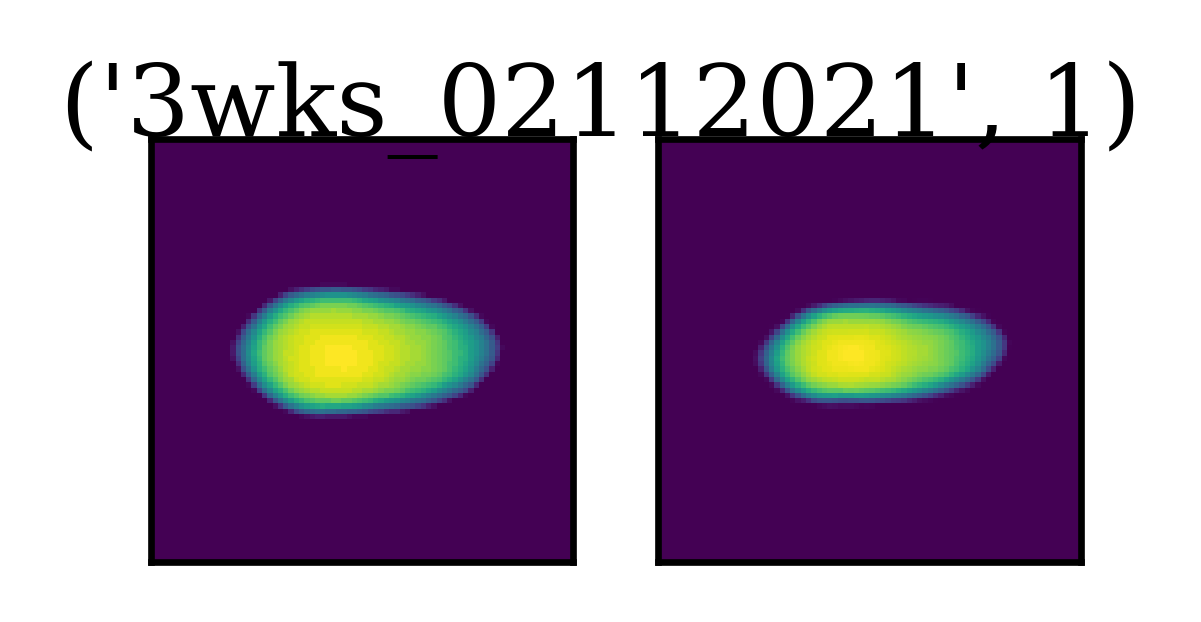

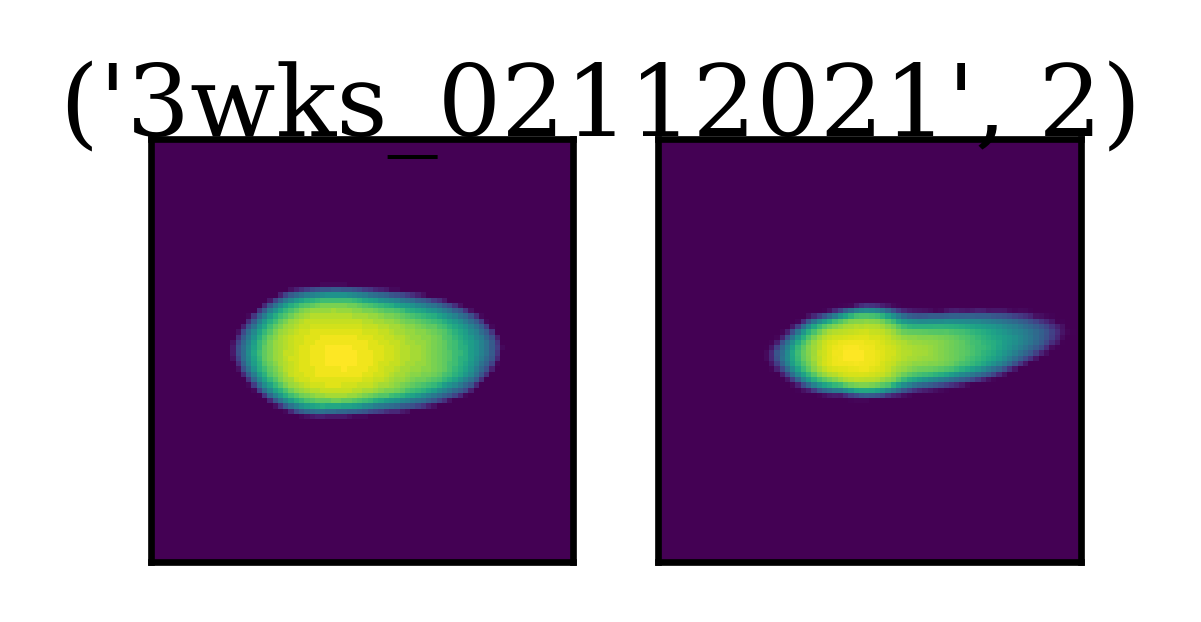

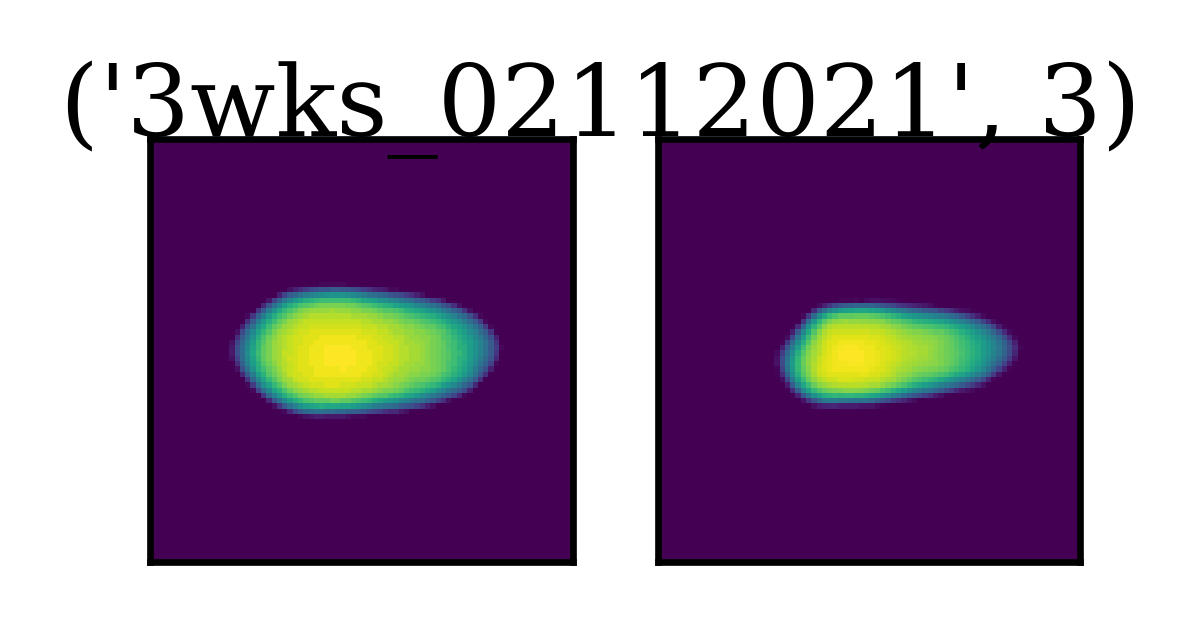

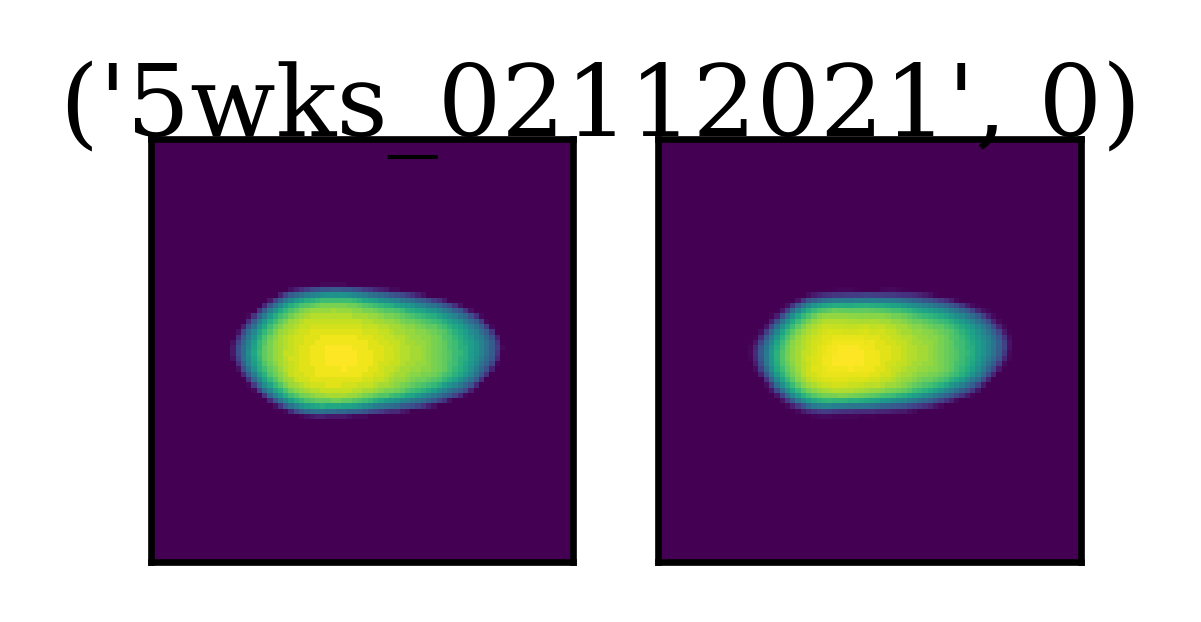

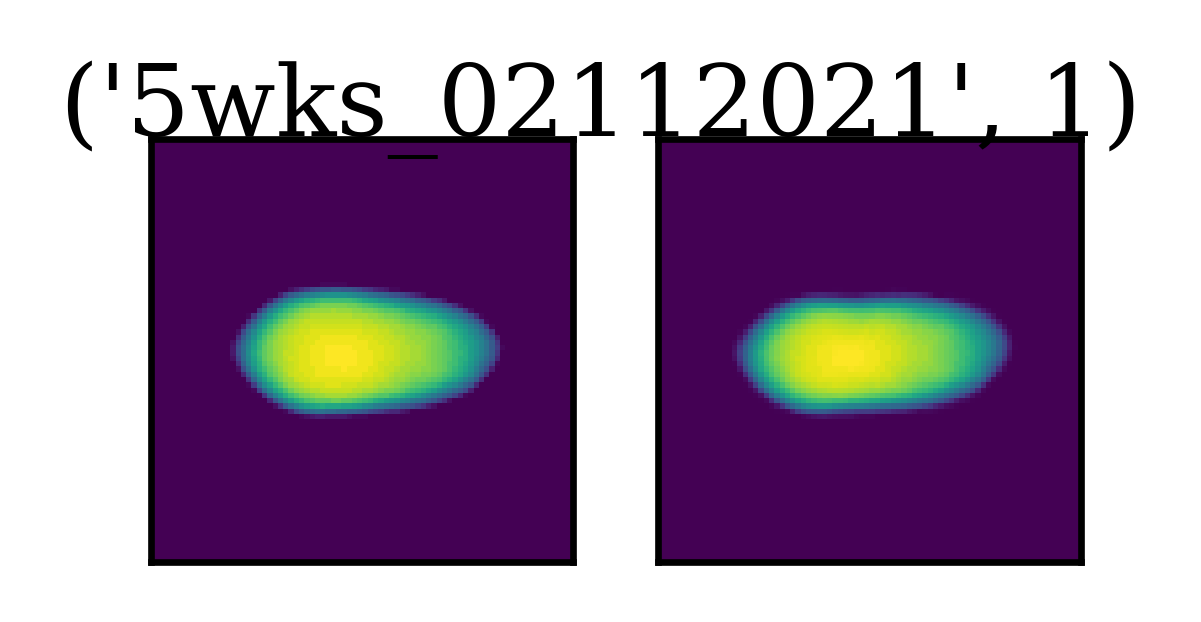

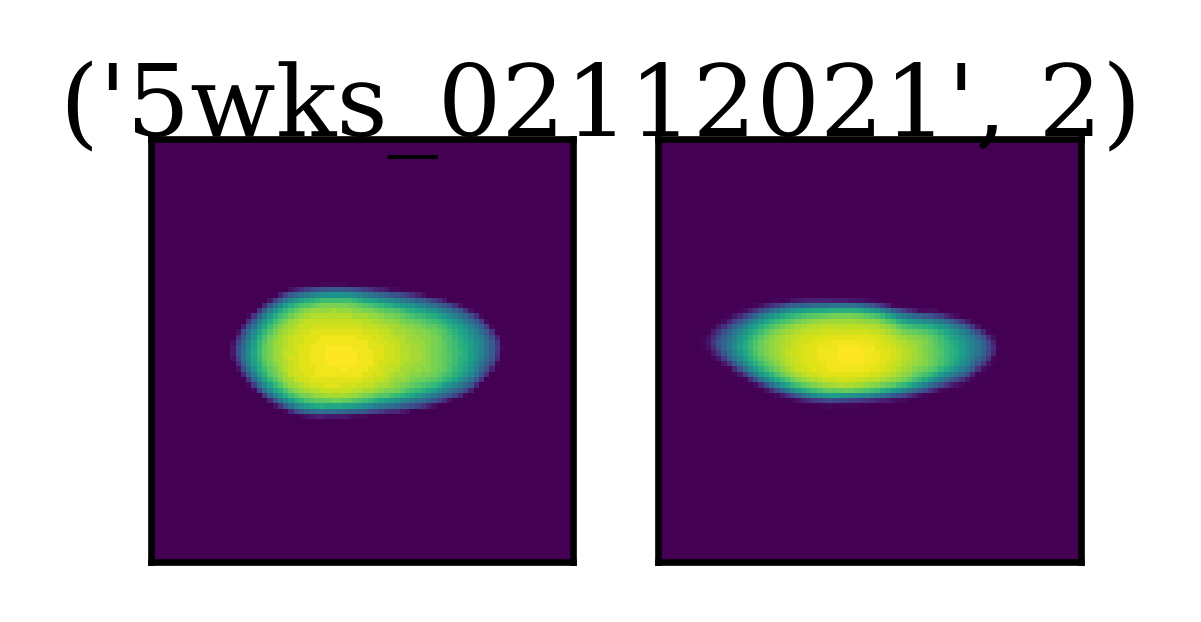

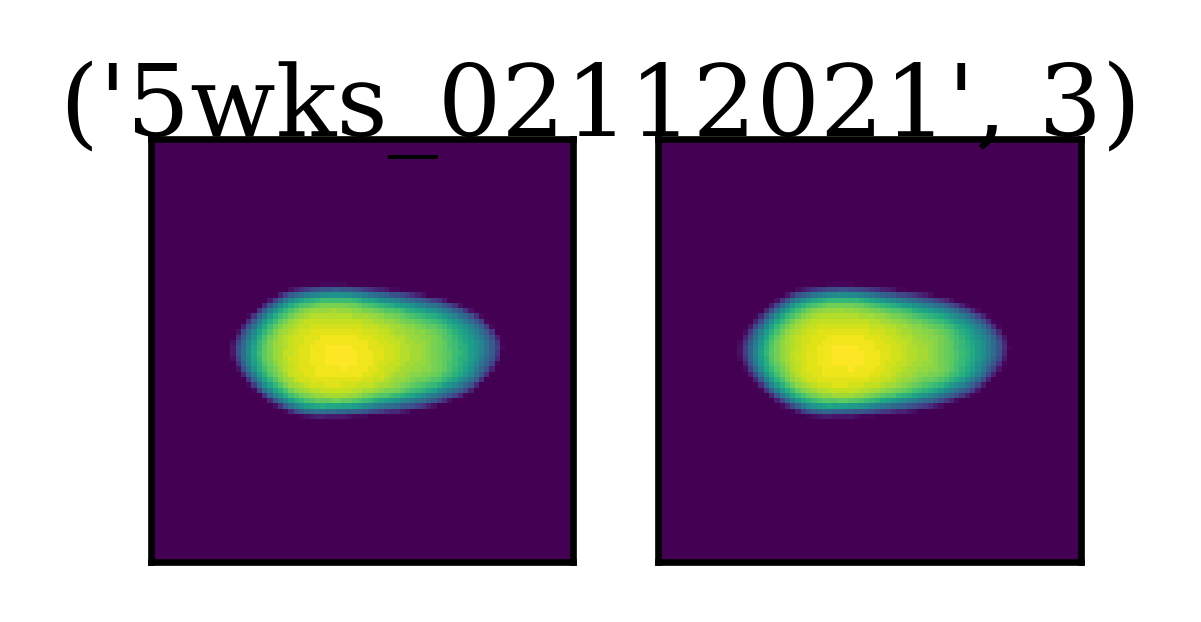

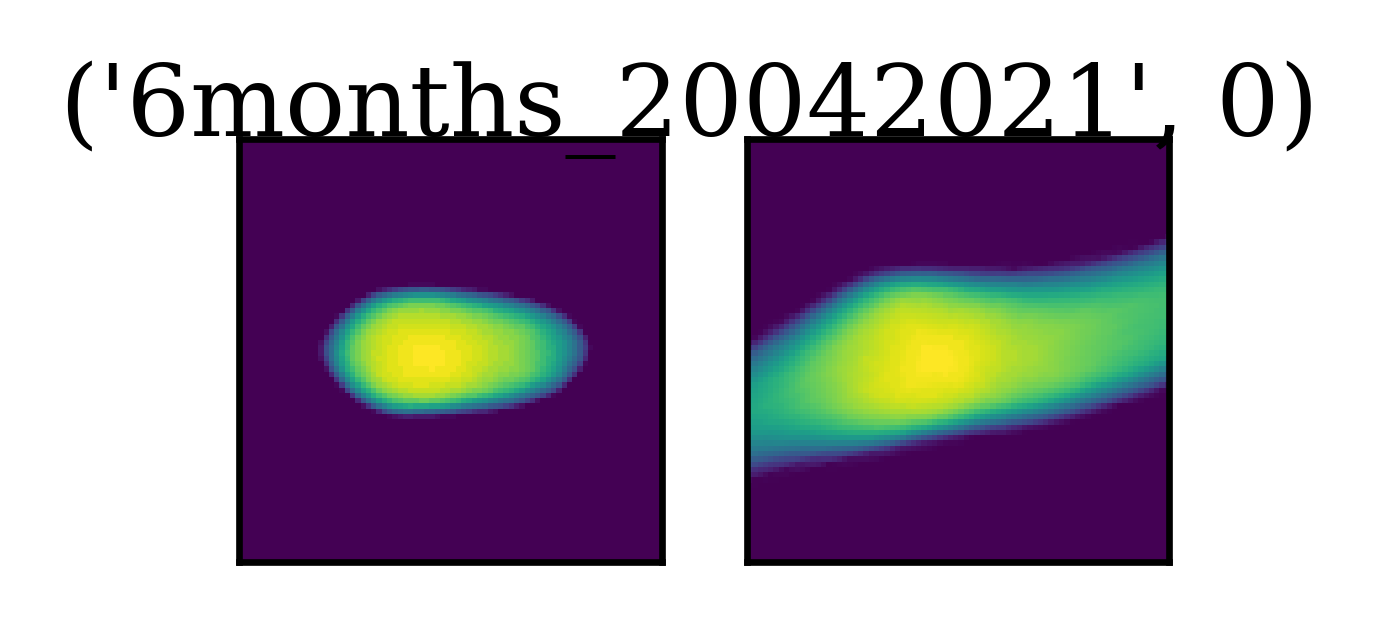

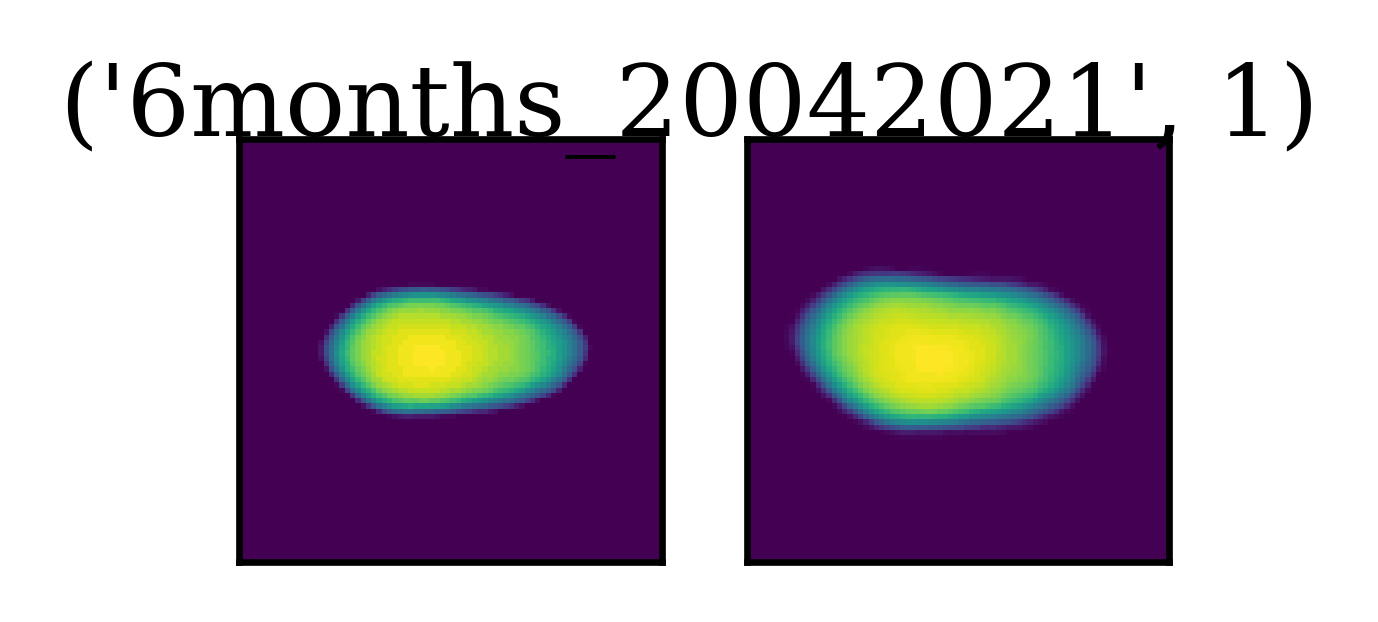

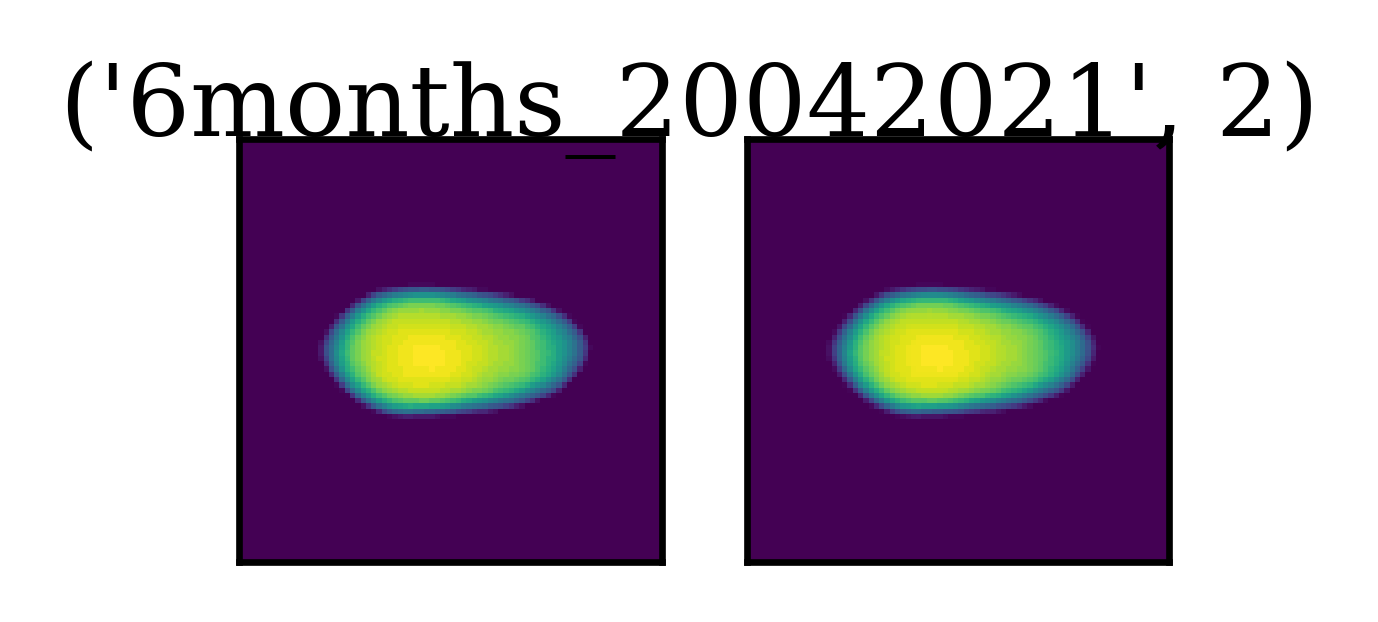

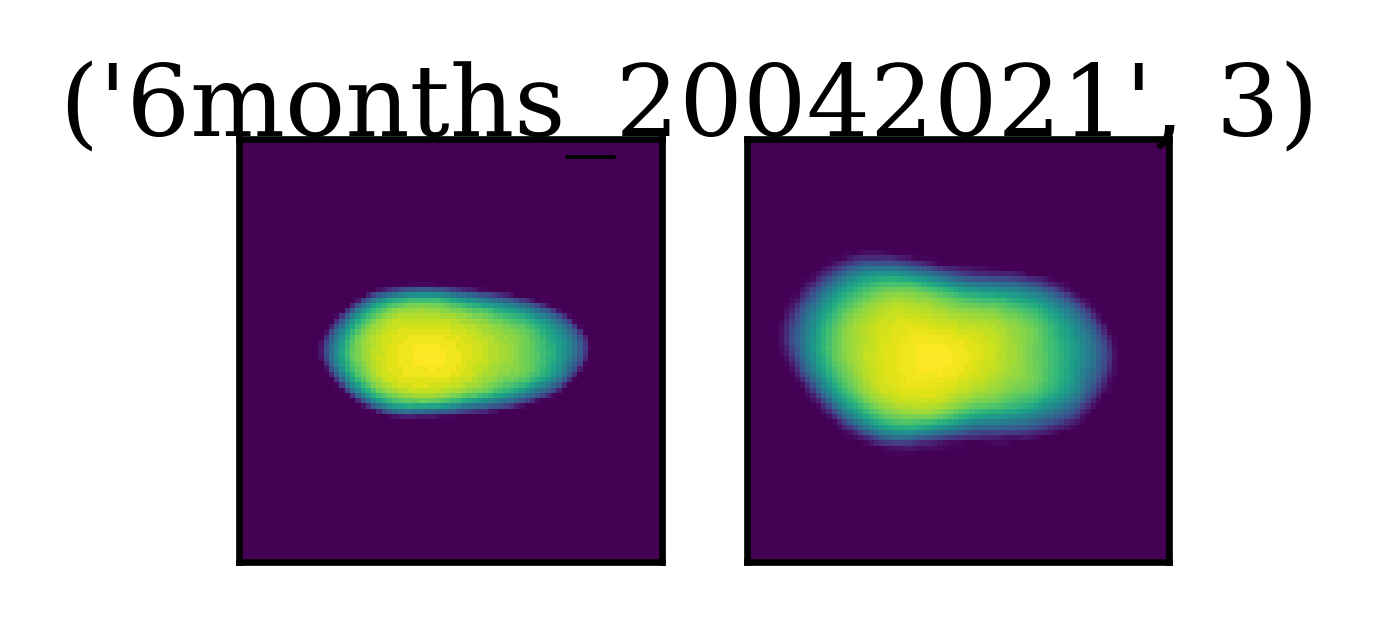

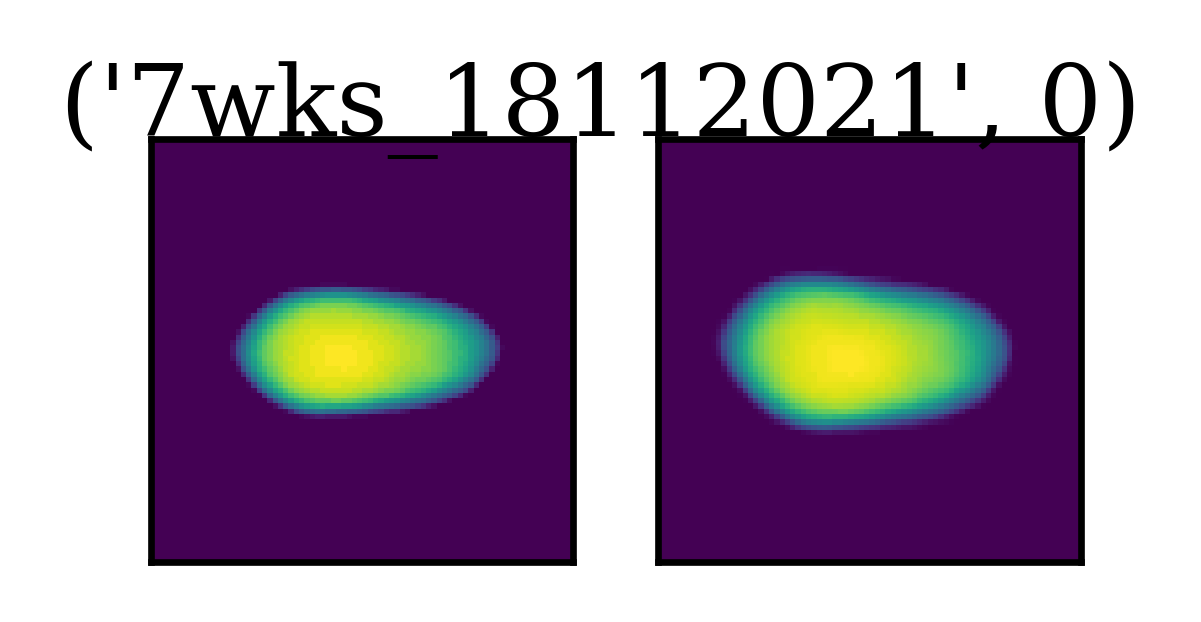

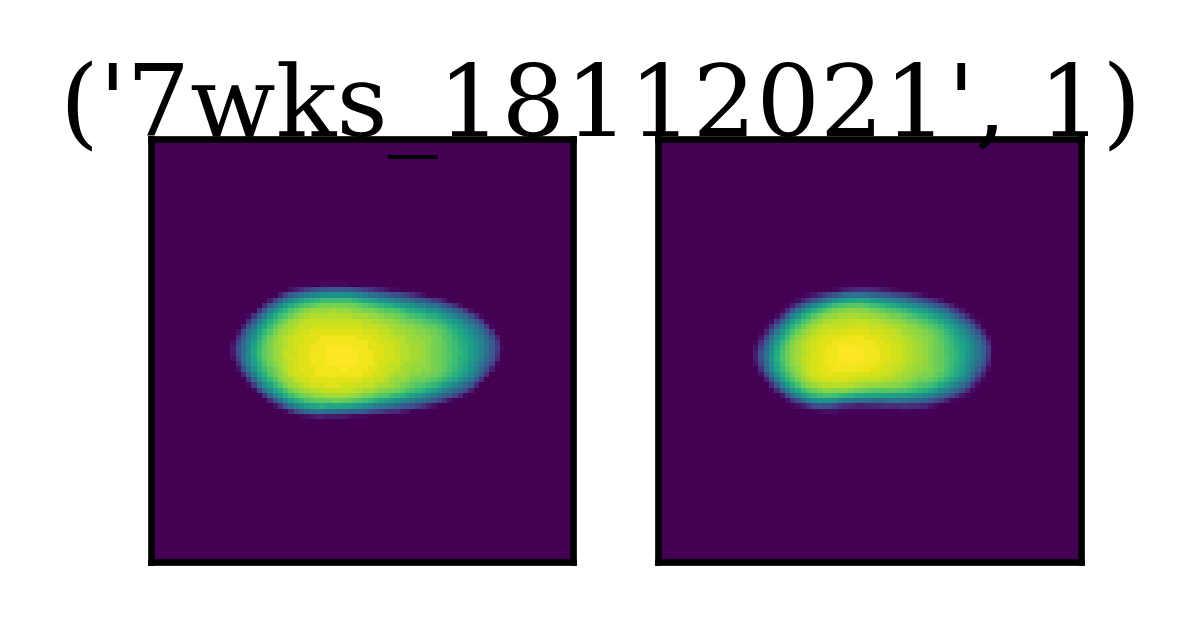

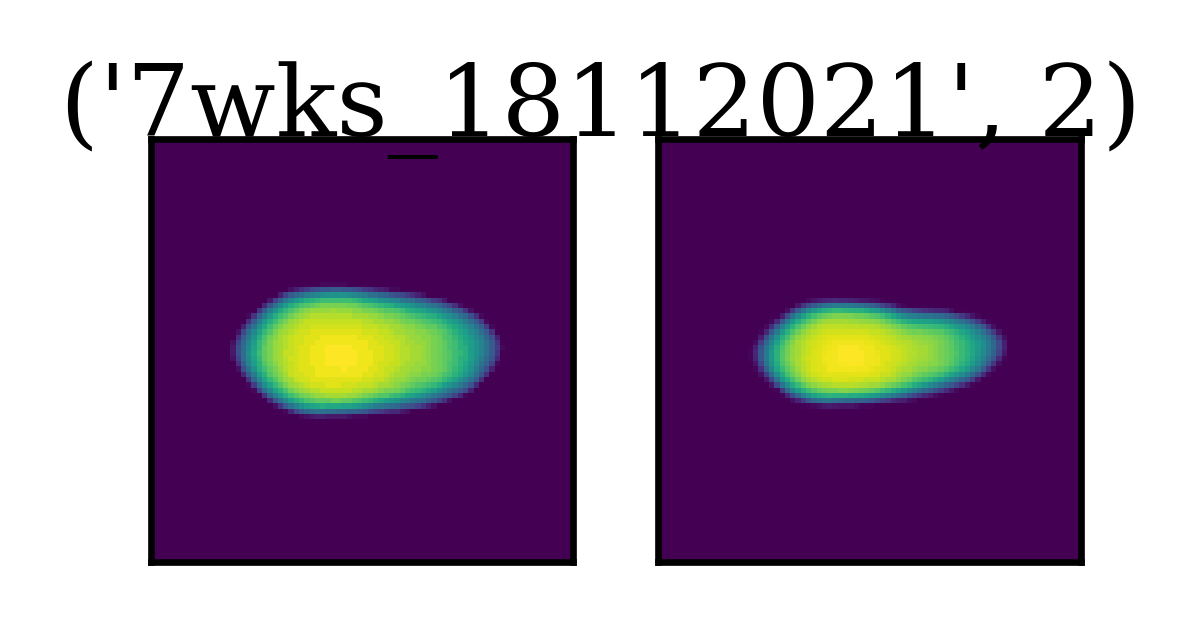

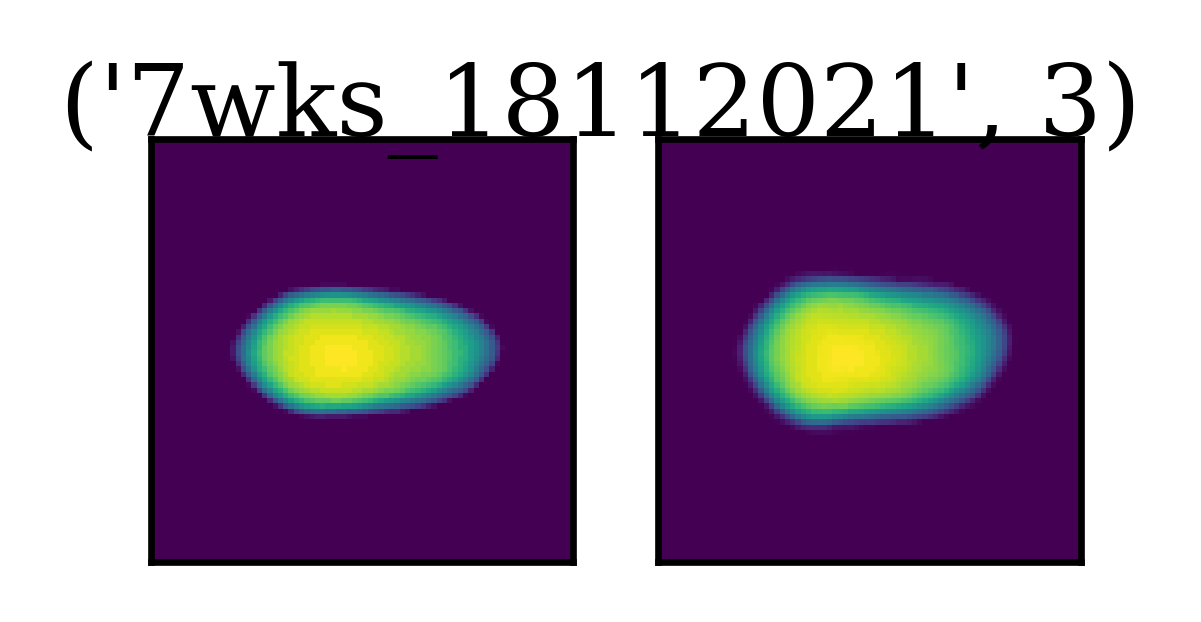

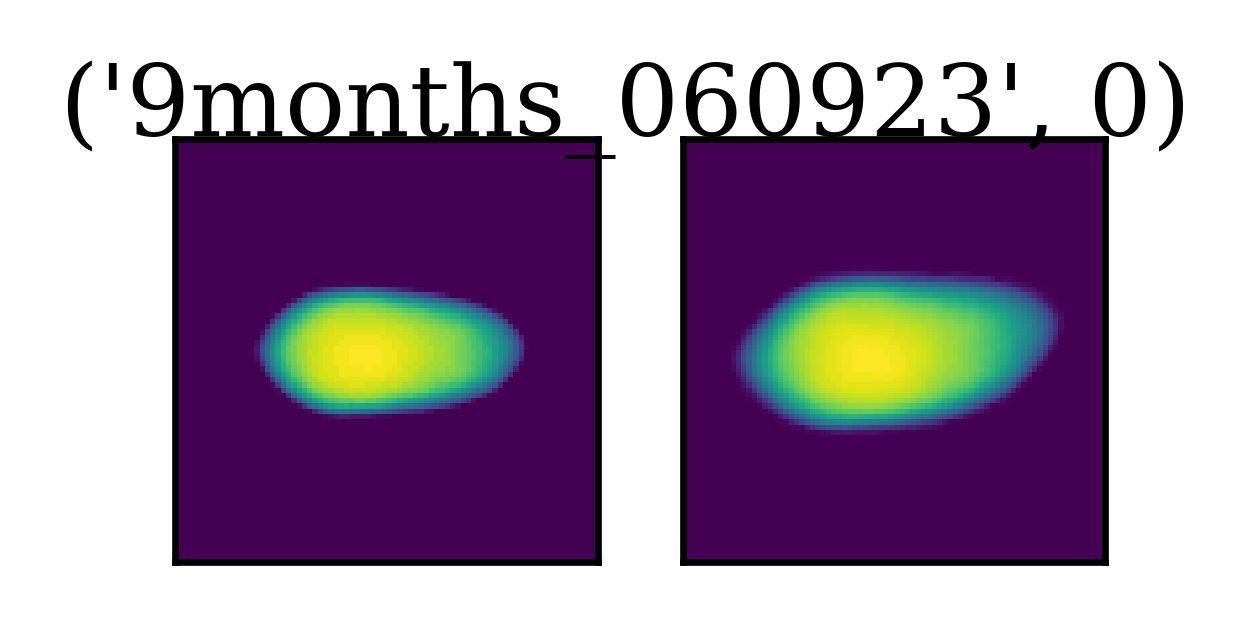

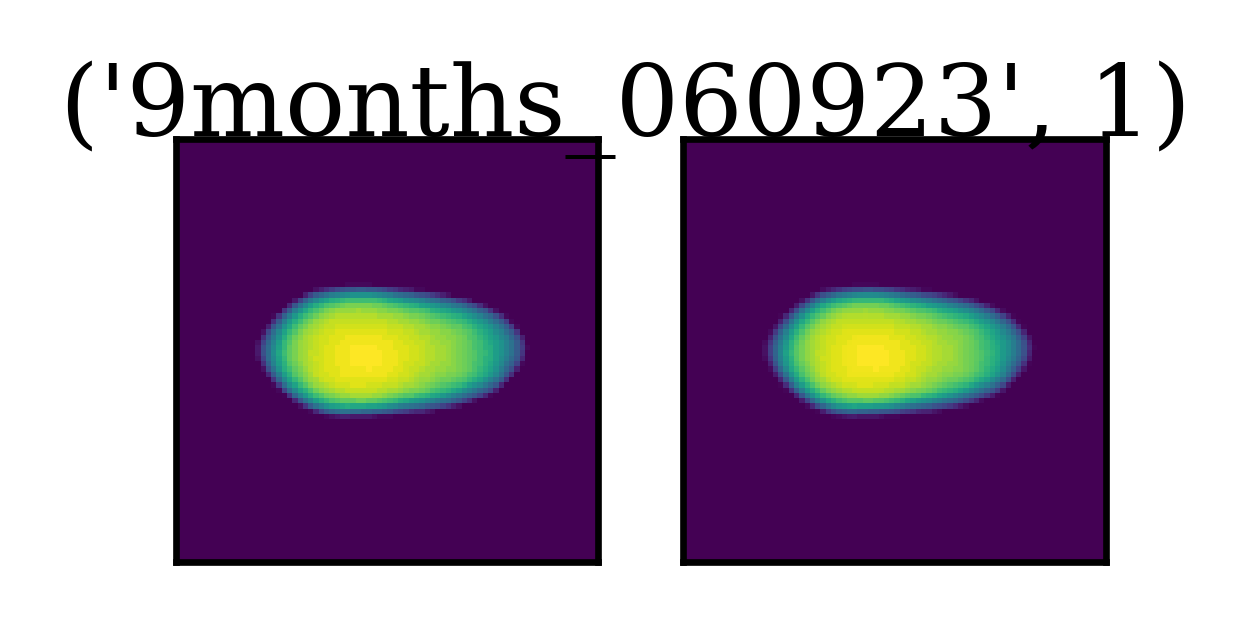

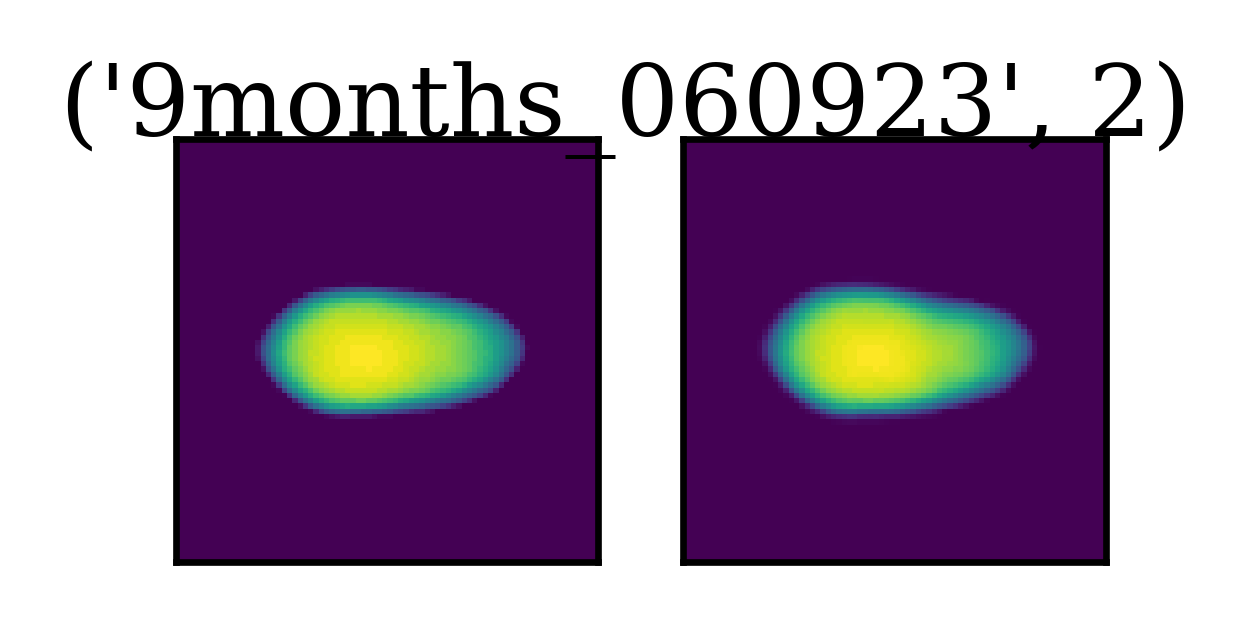

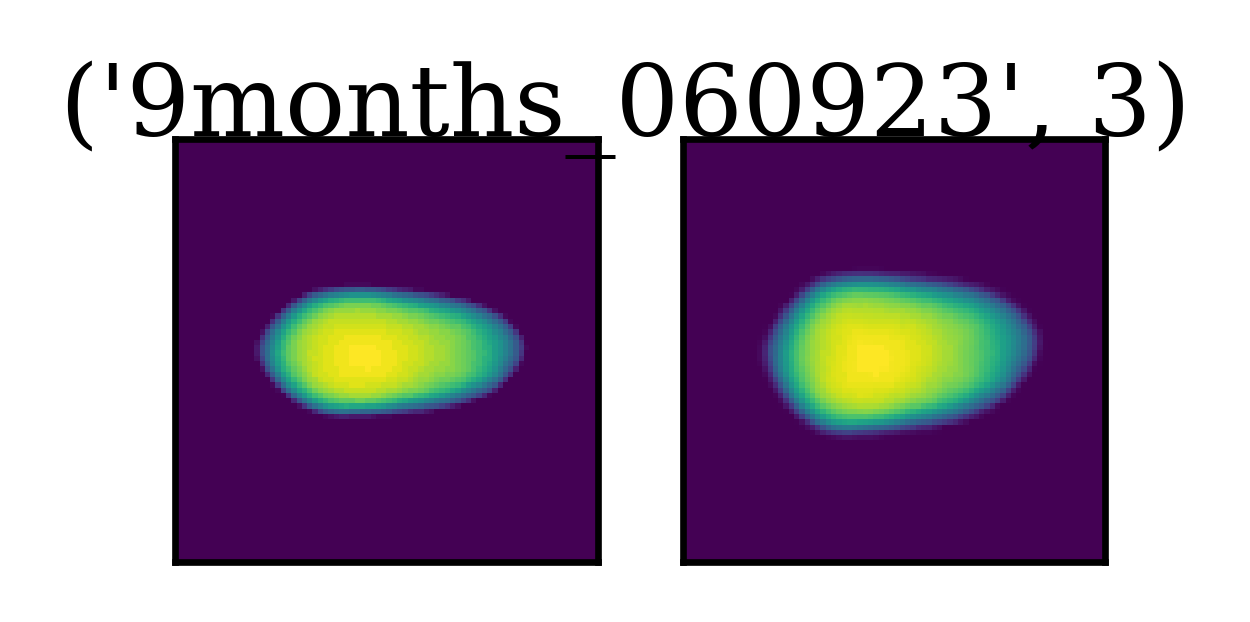

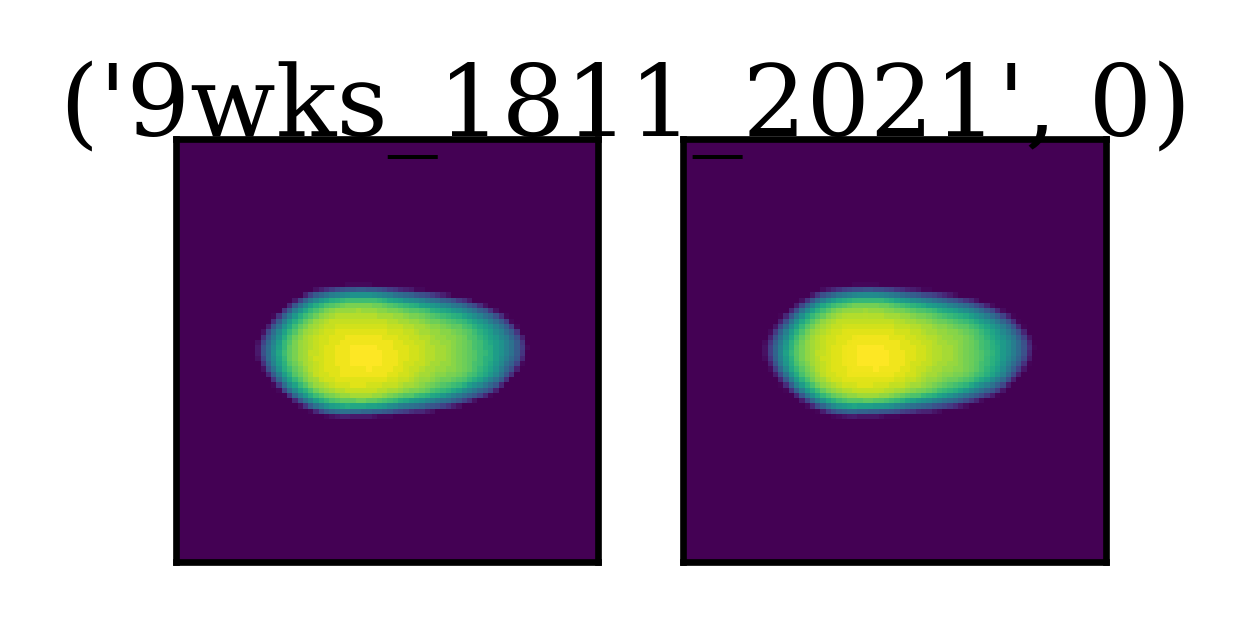

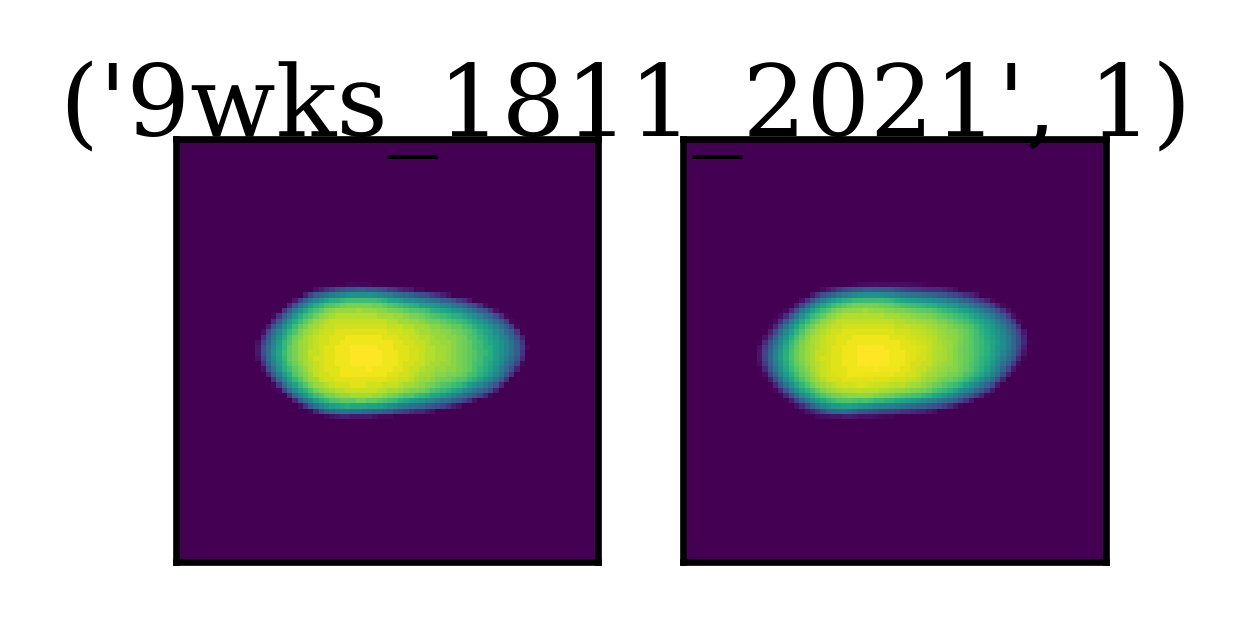

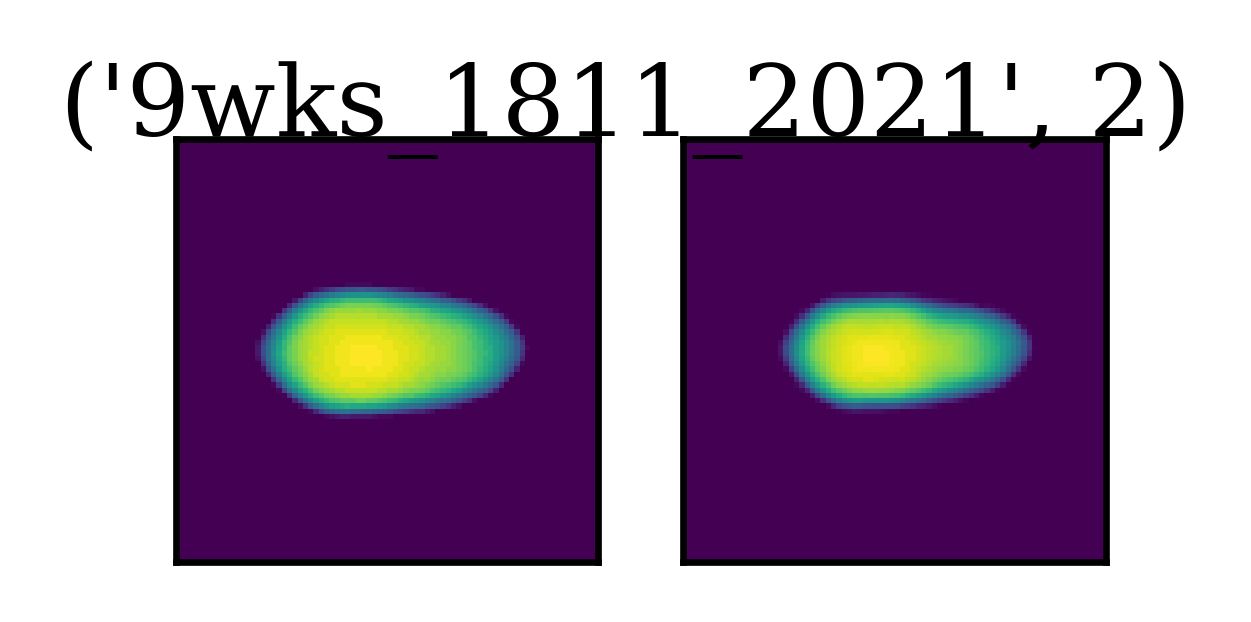

In [133]:
for k, v in warp_pts.items():
    for i, (source, target) in enumerate(v):
        fig, ax = plt.subplots(1, 2, figsize=(2, 1))
        ax[0].imshow(img)
        ax[1].imshow(warp(source, target, img))
        fig.suptitle((k, i))
        for a in ax:
            a.set(xticks=[], yticks=[])